In [1]:
using Revise

In [2]:
using PyCall, PyPlot, Statistics, JuMP
mpl = pyimport("matplotlib");
mpl.rcParams["lines.linewidth"] = 2;

In [3]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting
using ClimateMARGO.PolicyResponse

In [4]:
include("suboptimal_policy.jl");

# A policy process for responding to suboptimal climate outcomes

In [5]:
append_model!(model_list, model) = append!(model_list, [deepcopy(model)]);

In [6]:
base_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));
max_deployment = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>0., "adapt"=>0.);

## 1. Under-ambitious case

In [7]:
model = deepcopy(base_model)

temp_goal_list = [];
model_list = [];
hypo_model_list = [];

optimal = deepcopy(model)
optimal.physics.r = 0.75
optimize_controls!(optimal, temp_goal=1.5, temp_overshoot=10., max_deployment=max_deployment);

append_model!(model_list, model);
append_model!(hypo_model_list, model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Solve_Succeeded


In [8]:
function binary_search!(model, temp_goal; N=12)
    ΔT = 1.
    for i in 1:N
        temp_goal += ΔT
        m = optimize_controls!(model, temp_goal = temp_goal, temp_overshoot=10., max_deployment=max_deployment, print_raw_status=false)
        if (((raw_status(m) == "Solve_Succeeded") & (ΔT >= 0.)) | ((raw_status(m) != "Solve_Succeeded") & (ΔT <= 0.)))
            ΔT *= -0.5;
        else
            ΔT *= 0.5
        end
    end
    return temp_goal
end;

In [9]:
Δt = 10.
shortfall = 0.6

temp_goal_og = 1.5

for i in 1:10
    println("Evaluating policy in ", model.domain.present_year)
    temp_goal = temp_goal_og
    m = optimize_controls!(model, temp_goal = temp_goal, temp_overshoot = 10., max_deployment=max_deployment);
    if raw_status(m) != "Solve_Succeeded"
        temp_goal = binary_search!(model, temp_goal)
    end
    if temp_goal >= temp_goal_og
        print("Increased temperature goal to ", round(temp_goal, digits=3), "\n")
    end
    append_model!(hypo_model_list, model);
    suboptimal_step_forward!(model, model_list[end], Δt, 1. -shortfall);
    append_model!(model_list, model);
    append!(temp_goal_list, temp_goal);
end

Evaluating policy in 2020.0
Solve_Succeeded
Increased temperature goal to 1.5
Evaluating policy in 2030.0
Solve_Succeeded
Increased temperature goal to 1.5
Evaluating policy in 2040.0
Solve_Succeeded
Increased temperature goal to 1.5
Evaluating policy in 2050.0
Solve_Succeeded
Increased temperature goal to 1.5
Evaluating policy in 2060.0
Solve_Succeeded
Increased temperature goal to 1.5
Evaluating policy in 2070.0
Solve_Succeeded
Increased temperature goal to 1.5
Evaluating policy in 2080.0
Infeasible_Problem_Detected
Increased temperature goal to 1.5
Evaluating policy in 2090.0
Infeasible_Problem_Detected
Increased temperature goal to 1.543
Evaluating policy in 2100.0
Infeasible_Problem_Detected
Increased temperature goal to 1.571
Evaluating policy in 2110.0
Infeasible_Problem_Detected
Increased temperature goal to 1.571


In [10]:
ds = 0.025
shortfalls = collect(0.: ds : 1.0)
shortfalls[end] = 1. - ds/4.

maxTs = zeros(size(shortfalls))
endTs = zeros(size(shortfalls))
maxTs_control = zeros(size(shortfalls))
solve_succeeded = zeros(size(shortfalls))

Nt = 10
for (j, shortfall) in enumerate(shortfalls)
    print(j,"/",size(shortfalls,1),", ")
    model = deepcopy(base_model)
    model_control = deepcopy(base_model)
    
    for i in 1:Nt
        temp_goal = temp_goal_og
        model_prev = deepcopy(model)
        m = optimize_controls!(model, temp_goal = temp_goal, temp_overshoot=10., max_deployment=max_deployment, print_raw_status=false);
        if raw_status(m) != "Solve_Succeeded"
            temp_goal = binary_search!(model, temp_goal)
        end
        suboptimal_step_forward!(model, model_prev, Δt, 1. -shortfall);
        
        model_control_prev = deepcopy(model_control)
        if i==1
            m = optimize_controls!(model_control, temp_goal = temp_goal, temp_overshoot=10., max_deployment=max_deployment, print_raw_status=false);
        end
        suboptimal_step_forward!(model_control, model_control_prev, Δt, 1. -shortfall);
    end
    maxTs[j] = maximum(T(model, M=true, R=true));
    endTs[j] = T(model, M=true, R=true)[end]
    maxTs_control[j] = maximum(T(model_control, M=true, R=true));
end

1/41, 2/41, 3/41, 4/41, 5/41, 6/41, 7/41, 8/41, 9/41, 10/41, 11/41, 12/41, 13/41, 14/41, 15/41, 16/41, 17/41, 18/41, 19/41, 20/41, 21/41, 22/41, 23/41, 24/41, 25/41, 26/41, 27/41, 28/41, 29/41, 30/41, 31/41, 32/41, 33/41, 34/41, 35/41, 36/41, 37/41, 38/41, 39/41, 40/41, 41/41, 

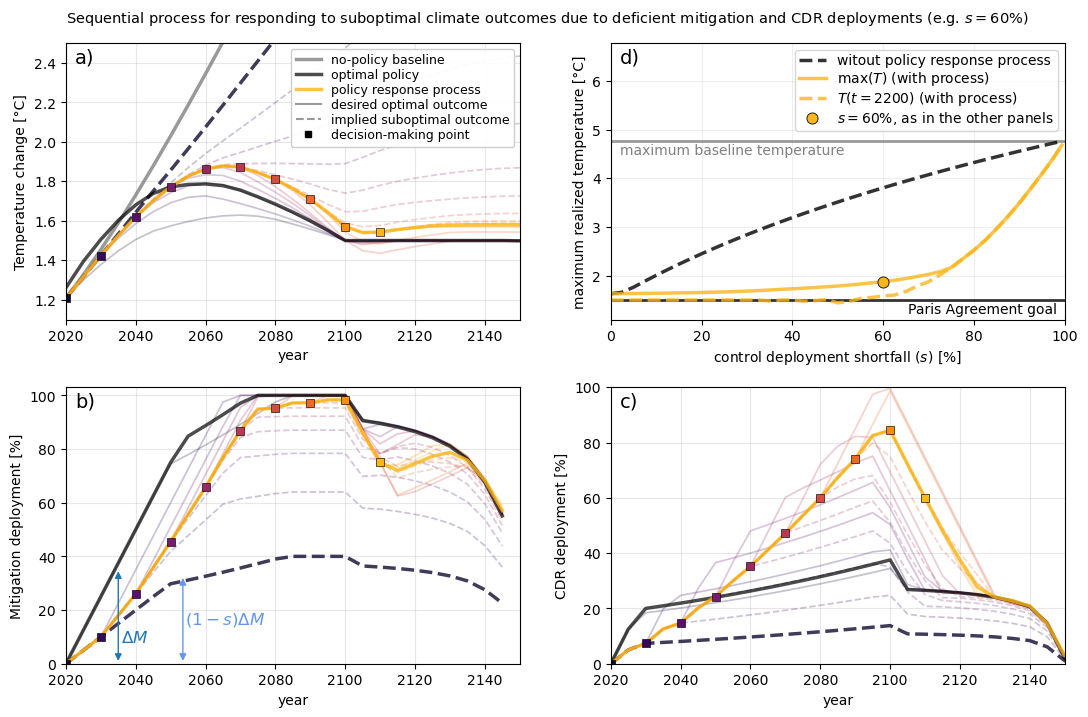

In [13]:
N = length(model_list)

xt = 2020:20:2150
xtn = convert(Array{Any}, copy(xt))
xtn[((xtn.-2000).%40).==0] .= nothing

arrowprops=Dict(
    "arrowstyle"=>"<|-|>",
    "fc"=>"cornflowerblue", "ec"=>"cornflowerblue"
)

arrowprops_b=Dict(
    "arrowstyle"=>"<|-|>",
    "fc"=>"C0", "ec"=>"C0"
)

alpha_step = 0.25
alpha_thick = 0.7
alpha_short = 0.8
lw_thick = 2.5
cmap = get_cmap("inferno");

figure(figsize=(11,7))

##
ax = subplot(2,2,1)
grid(true, alpha=0.3)
plot(t(base_model), T(base_model), "-", color="grey", label="no-policy baseline", lw=2.5, alpha=alpha_short)
for (i, m) in enumerate(model_list[2:end])
    if i==1; lw=2.5; alpha=alpha_short; else; lw=1.25; alpha=alpha_step; end
    plot(t(m), T(m, M=true, R=true), "--", color=cmap(i/(N+1)), lw=lw, alpha=alpha)
end

for (i, m) in enumerate(hypo_model_list[2:end])
    plot(t(m), T(m, M=true, R=true), "-", color=cmap(i/(N+1)), lw=1.25, alpha=alpha_step)
end
plot(t(optimal), T(optimal, M=true, R=true), "k", lw=lw_thick, alpha=alpha_thick, label="optimal policy")
m = model_list[end]
plot(t(m), T(m, M=true, R=true), lw=lw_thick, alpha=alpha_thick+0.1, color=cmap((N-1)/(N+1)), label="policy response process")
for (i, m) in enumerate(hypo_model_list[2:end])
    idx = (t(m) .== m.domain.present_year)
    plot(t(m)[idx], T(m, M=true, R=true)[idx], color=cmap(i/(N+1)), marker="s", markersize=5.5, markeredgecolor="k", markeredgewidth=0.45)
end
ylim([optimal.physics.T0, 2.5])
xlim([2020, 2150])
xlabel("year")
xticks(xt, xt)
plot([],[], "k-", alpha=0.4, label="desired optimal outcome")
plot([],[], "k--", alpha=0.4, label="implied suboptimal outcome")
plot([],[], "ks", label="decision-making point", markersize=5)
legend(loc=(0.495, 0.625), labelspacing = 0.16, fontsize=9, framealpha=0.95);
annotate("a)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=14)
ylabel("Temperature change [°C]")

##
subplot(2,2,2)
grid(true, alpha=0.2)
axhline(temp_goal_og, color="k", alpha=0.8, lw=2)
axhline(maximum(T(base_model)), color="grey", alpha=0.8, lw=2)
plot(shortfalls*100, maxTs_control, "k--", lw=2.5, alpha=0.8, label="witout policy response process")
plot(shortfalls*100, maxTs, color=cmap((N-1)/(N+1)), lw=2.5, alpha=0.8, label=L"$\max(T)$ (with process)")
plot(shortfalls*100, endTs, "--", color=cmap((N-1)/(N+1)), lw=2.5, alpha=0.8, label=L"$T(t=2200)$ (with process)")
plot(shortfall*100, maximum(T(model_list[end], M=true, R=true)), "o", color=cmap((N-1)/(N+1)), markersize=8,
    label=L"$s = 60\% $, as in the other panels", markeredgecolor="k", markeredgewidth=0.6
)
xlim(0, 100)
ylim([temp_goal_og-0.4, maximum(T(base_model))+2.])
xlabel(L"control deployment shortfall ($s$) [%]")
ylabel("maximum realized temperature [°C]")
annotate(s="maximum baseline temperature", xy=(2, maximum(T(base_model))-0.275), color="grey")
annotate(s="Paris Agreement goal", xy=(65.5, temp_goal_og-0.275), color="k")
legend(loc="upper right", borderpad=0.25, labelspacing=0.14)
annotate("d)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=14)

## 
subplot(2,2,3)
grid(true, alpha=0.3)
mmask = t(m) .< 2150
for (i, m) in enumerate(model_list[2:end])
    if i==1; lw=2.5; alpha=alpha_short; else; lw=1.25; alpha=alpha_step; end
    plot(t(m)[mmask], m.controls.mitigate[mmask], "--", color=cmap(i/(N+1)), lw=lw, alpha=alpha)
end
for (i, m) in enumerate(hypo_model_list[2:end])
    plot(t(m)[mmask], m.controls.mitigate[mmask], "-", color=cmap(i/(N+1)), lw=1.25, alpha=alpha_step)
end
plot(t(optimal)[mmask], optimal.controls.mitigate[mmask], "k-", lw=lw_thick, alpha=alpha_thick)
m = model_list[end]
plot(t(m)[mmask], m.controls.mitigate[mmask], lw=lw_thick, alpha=alpha_thick+0.1, color=cmap((N-1)/(N+1)))
for (i, m) in enumerate(hypo_model_list[2:end])
    idx = (t(m) .== m.domain.present_year)
    plot(t(m)[idx], m.controls.mitigate[idx], color=cmap(i/(N+1)), marker="s", markersize=5.5, markeredgecolor="k", markeredgewidth=0.45)
end
xlim([2020, 2150])
xlabel("year")
xticks(xt, xt)
yt = 0.:0.2:1.
yticks(yt, Int.(yt*100))
ylim(0, 1.03)
ylabel("Mitigation deployment [%]")
annotate("b)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=14)

annotate("", (2035, 0.), xytext=(2035, 0.355), arrowprops=arrowprops_b)
annotate(L"$\Delta M$", (2035.75, 0.08), fontsize=12, color="C0");

annotate("", (2053.5, 0.), xytext=(2053.5, 0.33), arrowprops=arrowprops)
annotate(L"$(1-s)\Delta M$", (2054.25, 0.15), fontsize=12, color="cornflowerblue");

subplot(2,2,4)
grid(true, alpha=0.3)
for (i, m) in enumerate(model_list[2:end])
    if i==1; lw=2.5; alpha=alpha_short; else; lw=1.25; alpha=alpha_step; end
    plot(t(m), m.controls.remove, "--", color=cmap(i/(N+1)), lw=lw, alpha=alpha)
end
for (i, m) in enumerate(hypo_model_list[2:end])
    plot(t(m), m.controls.remove, "-", color=cmap(i/(N+1)), lw=1.25, alpha=alpha_step)
end
plot(t(optimal), optimal.controls.remove, "k-", lw=lw_thick, alpha=alpha_thick)
m = model_list[end]
plot(t(m), m.controls.remove, lw=lw_thick, alpha=alpha_thick+0.1, color=cmap((N-1)/(N+1)))
for (i, m) in enumerate(hypo_model_list[2:end])
    idx = (t(m) .== m.domain.present_year)
    plot(t(m)[idx], m.controls.remove[idx], color=cmap(i/(N+1)), marker="s", markersize=5.5, markeredgecolor="k", markeredgewidth=0.45)
end
xlim([2020, 2150])
xlabel("year")
xticks(xt, xt)
yt = 0.:0.2:1.
yticks(yt, Int.(yt*100))
ylim(0, 1.)
ylabel("CDR deployment [%]")
xticks()
annotate("c)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=14)
tight_layout(w_pad=1.8)

shortfall_percentage = abs(Int(round(shortfall*100)))
ax.set_title(
    string(L"Sequential process for responding to suboptimal climate outcomes due to deficient mitigation and CDR deployments (e.g. $s=$","$(shortfall_percentage)%)"),
    loc="left", y=1.045, fontsize=10.5
)

savefig("figures/supp_scenario-A_shortfall_overshoot.png", dpi=250., bbox_inches="tight")